In [1]:
import csv
import pandas as pd
import math
import numpy as np
from scipy import stats
# Use svg backend for better quality
import matplotlib
# AUTOLAB_IGNORE_START
matplotlib.use("svg")
# AUTOLAB_IGNORE_STOP
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) # you should adjust this to fit your screen
# AUTOLAB_IGNORE_STOP

In [7]:
df = pd.read_csv("table.csv")
df = df.drop(['Hrs Per Week 5', 'Hrs Per Week 8'], axis=1)
df = df[pd.notnull(df['Num'])]
temp = []
for item in df["Num"]:
    temp.append(item.replace("-",""))
df["Num"] = temp
df = df[df.Num.apply(lambda x: x.isnumeric())]
df["Num"] = df["Num"].astype("int64")
df = df[df["Possible Respondents"] > 10]
df = df[df["Response Rate %"] > 20]

print(df.dtypes)
print(df.head())
print(df.isna().any())
# print(df.loc[:, df.isna().any()])
print(df.shape)

Year                                                     int64
Semester                                                object
Dept                                                    object
Num                                                      int64
Section                                                 object
Name                                                    object
Course Name                                             object
Level                                                   object
Possible Respondents                                     int64
Num Respondents                                          int64
Response Rate %                                        float64
Hrs Per Week                                           float64
Interest in student learning                           float64
Clearly explain course requirements                    float64
Clear learning objectives & goals                      float64
Instructor provides feedback to students to improve    

slope: 1.014652519884493
intercept: -0.1778610729052268
r_value: 0.9345590516315659
p_value: 9.50477992929775e-37
std_error: 0.04374002998808122


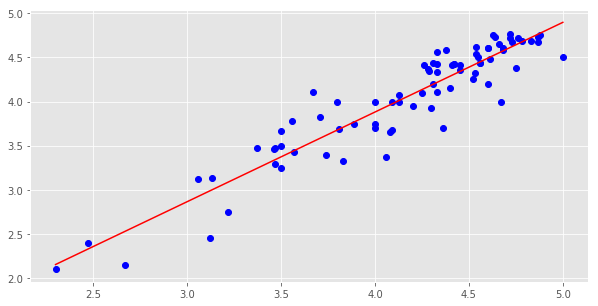

In [8]:
def plot_against_overall(category, df, dept=None, course_level=None, overall_category="Overall course rate"):
    """
    Inputs: category (string), category of interest in the dataframe
            df (pandas.dataframe), dataframe
            dept (string), major department
            course_level (int), 100,200,300... level of difficulty
            overall_category (string), overall course rate or overall teaching rate
    
    Output: matplotlib graph of category vs overall
            returns nothing
    """
    given = []
    overall = []
    if dept != None:
        df = df[df["Dept"]==dept]
    if course_level != None:
        level = course_level//100
        for item in df['Num']:
            if not isinstance(item, int):
                print(item)
        df = df[(df['Num']//100)%10 == level]
    for i,row in df.iterrows():
        item = row[category]
        total = row[overall_category]
        if pd.notnull(item) and pd.notnull(total):
            given.append(item)
            overall.append(total)
    x = given
    y = overall
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("slope:", slope)
    print("intercept:", intercept)
    print("r_value:", r_value)
    print("p_value:", p_value)
    print("std_error:", std_err)
    mn=np.min(x)
    mx=np.max(x)
    x1=np.linspace(mn,mx,500)
    y1=slope*x1+intercept
    plt.plot(x,y,'ob')
    plt.plot(x1,y1,'-r')
    return
    
p = plot_against_overall("Clearly explain course requirements", df, "ECE", 300)
plt.show()